# Image Captioning

### Group 9
- SIVA MANOHAR KOKI	           
- KUMMARI HEMALATHA 							 			
- SUPRIYA KANCHARLA 
- VASILEIOS DROGKOULAS


### Import required libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 
from keras.models import Sequential
import sys, time, os, warnings
import string
from copy import copy

from collections import Counter
warnings.filterwarnings('ignore')
import torch

#from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import img_to_array,load_img

#from tensorflow.keras.utils import load_img
from IPython.display import display
from PIL import Image

### Load Flicker_8k Dataset

In [4]:
# Google Drive is used to store and retrieve the dataset
from google.colab import drive
drive.mount('/content/gdrive')

# Load images
flicker8k_images = "/content/gdrive/My Drive/NLP_Project/Flicker8k_Dataset/"

# Load captions
flicker8k_captions = "/content/gdrive/My Drive/NLP_Project/Flickr8k_text/Flickr8k.token.txt"

total_images = os.listdir(flicker8k_images)
print("Number of images in Flicker_8k dataset: ", len(total_images))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Number of images in Flicker_8k dataset:  8091


### Load captions and map them to images

In [5]:
# Read captions file
captions_file = open(flicker8k_captions, 'r', encoding='utf8')
captions = captions_file.read()
captions_file.close()

# Sample data from captions file
# 1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting

captionsfile_data = []

for new_line in captions.split('\n'):
  # Position 0 : image name and index
  # Position 1 : caption text
  columns = new_line.split('\t')
  if len(columns) == 1:
    continue
  
  # Split image name and index
  image_index = columns[0].split("#")
  # store split data into list
  captionsfile_data.append(image_index + [columns[1].lower()])

# Create a dataframe containing captions mapped to the images.
captions_df = pd.DataFrame(captionsfile_data, columns=["filename","index","caption"])


image_names = np.unique(captions_df.filename.values)

print("Captions paired with each image:")

display(captions_df.head())

Captions paired with each image:


,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...


## EDA
### Display few images with captions

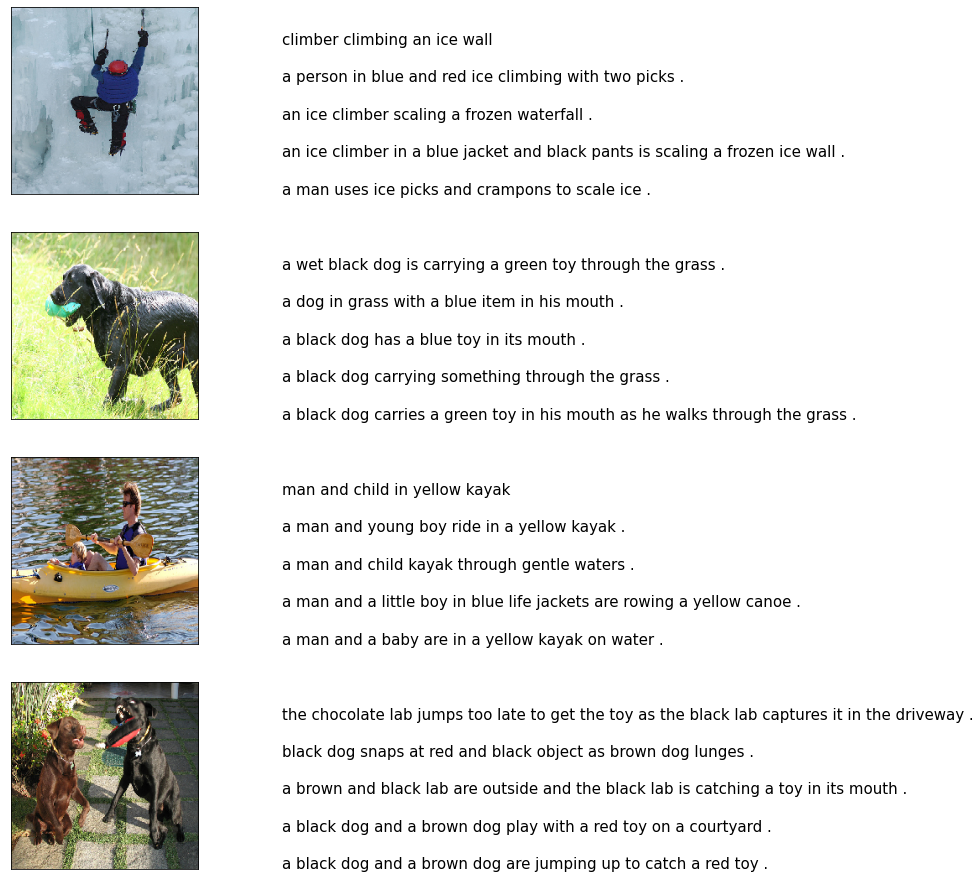

In [6]:
cnt = 1 
fig = plt.figure(figsize=(10,20))

for filename in image_names[21:25]:
  image_name = flicker8k_images + '/' + filename
  caption_input = list(captions_df["caption"].loc[captions_df["filename"]==filename].values)
  image = load_img(image_name, target_size= (224, 224, 3))
    
  ax = fig.add_subplot(5, 2, cnt, xticks=[], yticks=[])
  ax.imshow(image)
  cnt += 1
    
  ax = fig.add_subplot(5, 2 , cnt)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0, len(caption_input))
  for i, cpt in enumerate(caption_input):
      ax.text(0, i, cpt, fontsize=15)
  cnt += 1

plt.show()    

### Top five words from all captions

In [7]:
# Function that returns a dataframe with word and its count in total vocabulary
def word_count(captions_df):
    vocab = []
    
    for cptn in captions_df.caption.values:
        vocab.extend(cptn.split())

    print('Vocabulary_Size: ', len(set(vocab)))
    
    word_ct = Counter(vocab)
    #print( word_ct.most_common(5))

    word_count_df = pd.DataFrame({'Word':list(word_ct.keys()), "Count":list(word_ct.values())})
    word_count_df = word_count_df.sort_values("Count",ascending=False)
    word_count_df = word_count_df.reset_index()[["Word", "Count"]]
    
    return (word_count_df)

word_count_df = word_count(captions_df)
word_count_df.head()

Vocabulary_Size:  8918


,Word,Count
0,a,62989
1,.,36581
2,in,18975
3,the,18419
4,on,10744


### Data Cleaning

The captions dataset needs to be cleaned before being input to the model because it contains punctuation, singular words, and numerical values.

In [8]:
# Delete punctuation
def delete_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Delete single character
def delete_single_char(text):
    output = ""
    for w in text.split():
        if len(w) > 1:
            output += " " + w
    return output

# Delete numbers
def delete_numbers(text):
    output = ""
    for w in text.split():
        is_char = w.isalpha()
        if is_char:
            output += " " + w
    return output

def upper_to_lower_case(text):
   return text.lower()


In [9]:
def caption_clean(input_text):
    
    output_text = upper_to_lower_case(input_text)
    output_text = delete_punctuation(output_text)
    output_text = delete_single_char(output_text)
    output_text = delete_numbers(output_text)
    
    return output_text

for i,caption in enumerate(captions_df.caption.values):
    clean_caption = caption_clean(caption)
    captions_df['caption'].iloc[i] = clean_caption

### Display top and least 50 words

Vocabulary_Size:  8763


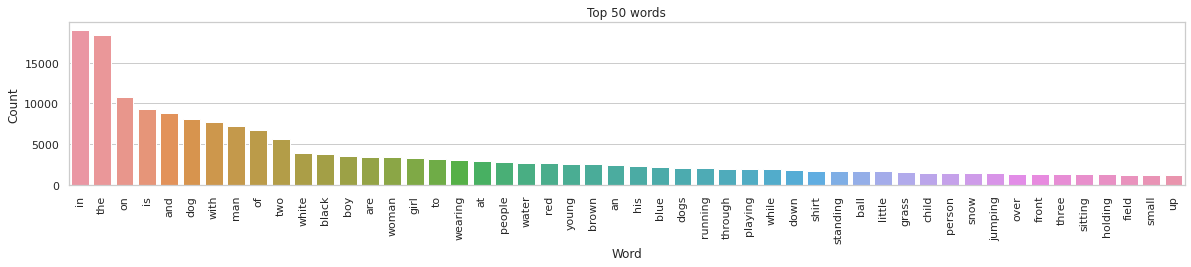

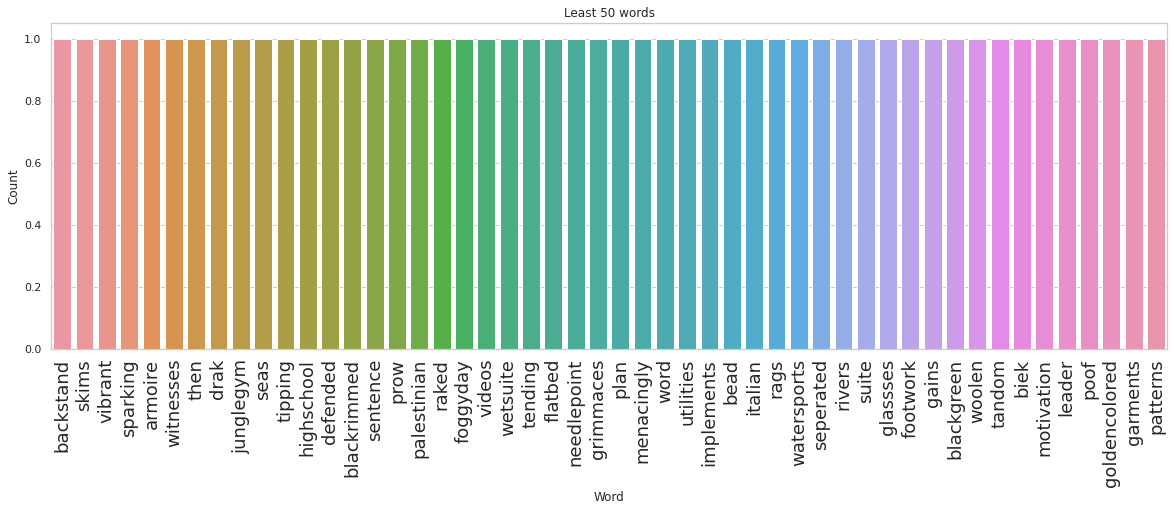

In [10]:
import seaborn as sns

word_ct = word_count(captions_df)

sns.set(style='whitegrid')
plt.figure(figsize=(20,3))
sns.barplot(x='Word', y='Count', data= word_ct.iloc[:50,:])
plt.xticks(rotation='vertical')
plt.title("Top 50 words")
plt.show()

plt.figure(figsize=(20,6))
sns.barplot(x='Word', y='Count', data= word_ct.iloc[-50:,:])
plt.xticks(rotation=90, fontsize=18)
plt.title("Least 50 words")
plt.show()

### Append start and end sequence tokens

Add start sequence and end sequence to tokens

In [11]:
def add_start_end_tokens(input_caption):
    tokens = []
    for text in input_caption:
        text = "startseq"+ text +" endseq"
        tokens.append(text)
    return tokens

captions_df0 = copy(captions_df)
captions_df0["caption"] = add_start_end_tokens(captions_df["caption"])
captions_df0.head(5)

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up se...
1,1000268201_693b08cb0e.jpg,1,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,2,startseq little girl climbing into wooden play...
3,1000268201_693b08cb0e.jpg,3,startseq little girl climbing the stairs to he...
4,1000268201_693b08cb0e.jpg,4,startseq little girl in pink dress going into ...


## Feature Extraction using VGG16

To extract the features, a pre-trained VGG-16 model that has previously been trained on a sizable amount of data is used. Imagenet weights are employed. To utilize VGG as a feature extractor, remove the final soft-max layer.


In [12]:
from keras.applications import VGG16
from keras import models

def VGG_16_model():
  #Loading VGG model
  vgg_model = VGG16(include_top = True, weights = 'imagenet')
  model = Sequential()
  #Removing last layer of vgg model
  for layer in vgg_model.layers[:-1]: 
      model.add(layer)
  
  # Re-structuring the model
  vgg_final_model = models.Model(inputs= model.inputs, outputs= model.layers[-1].output) 
  #Summarize
  print(vgg_final_model.summary())

  return vgg_final_model


In [13]:
import torch
#from keras.preprocessing.image import load_img,  img_to_array
from tensorflow.keras.utils import img_to_array,load_img

# example of loading an image with the Keras API

from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

#calling Vgg model
extract_features = VGG_16_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
images = OrderedDict()
data = np.zeros((len(total_images), 224, 224, 3))

#extract features from each image
for image_num, image_name in enumerate(total_images):
  print(image_num)
  #load image from dataset
  imagename = flicker8k_images + '/' + image_name
  load_image = load_img(imagename, target_size= (224, 224, 3))
  #converting image pixels to a numpy array
  image_array = img_to_array(load_image)
  n_image = preprocess_input(image_array)
    
  #get features
  features = extract_features.predict(n_image.reshape((1,)+ n_image.shape[:3]))
  images[image_name] = features.flatten()
  
  if image_num == 3000:
    torch.save(images,'/content/gdrive/My Drive/NLP_Project/cnn_new_5.pt')
    break

0
1/1 [==============================] - 1s 1s/step
1
1/1 [==============================] - 1s 558ms/step
2
1/1 [==============================] - 1s 554ms/step
3
1/1 [==============================] - 1s 528ms/step
4
1/1 [==============================] - 1s 549ms/step
5
1/1 [==============================] - 1s 534ms/step
6
1/1 [==============================] - 1s 528ms/step
7
1/1 [==============================] - 1s 520ms/step
8
1/1 [==============================] - 1s 540ms/step
9
1/1 [==============================] - 1s 531ms/step
10
1/1 [==============================] - 1s 568ms/step
11
1/1 [==============================] - 1s 548ms/step
12
1/1 [==============================] - 1s 548ms/step
13
1/1 [==============================] - 1s 537ms/step
14
1/1 [==============================] - 1s 551ms/step
15
1/1 [==============================] - 1s 547ms/step
16
1/1 [==============================] - 1s 550ms/step
17
1/1 [==============================] - 1s 529ms/step
18
1/

In [14]:
# Load extracted images saved in .pt file
image = torch.load('/content/gdrive/My Drive/NLP_Project/cnn_new_5.pt')


In [15]:
image_features, image_index = [], []

#Reading captions from dataframe
for i, file in enumerate(captions_df0.filename):
    if file in image.keys():
        image_features.append(image[file])
        image_index.append(i)
        
# Image name
file_name = captions_df0["filename"].iloc[image_index].values

# Image captions
image_captions = captions_df0["caption"] .iloc[image_index].values

# Images features
image_features = np.array(image_features)

captions_df0.head()

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up se...
1,1000268201_693b08cb0e.jpg,1,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,2,startseq little girl climbing into wooden play...
3,1000268201_693b08cb0e.jpg,3,startseq little girl climbing the stairs to he...
4,1000268201_693b08cb0e.jpg,4,startseq little girl in pink dress going into ...


## Tokenization

Texts must be converted into vectors because the model cannot accept text as an input.

In [16]:
from keras.preprocessing.text import Tokenizer

## Maximum words
max_words = 5000

tokenizer = Tokenizer(nb_words= max_words)
# Create vocabulary from captions
tokenizer.fit_on_texts(image_captions)

# Vocabulary length
len_vocab = len(tokenizer.word_index) + 1

# Create tokenized vectors
tokens = tokenizer.texts_to_sequences(image_captions)
print(tokens[:3])

print("Length of Vocabulary: ", len_vocab)
print("Yellow ID: ", tokenizer.word_index['yellow'])
print("Dog ID: ", tokenizer.word_index['dog'])

[[1, 39, 18, 188, 3, 572, 116, 3, 45, 11, 542, 1037, 9, 62, 242, 3, 1081, 2], [1, 39, 18, 6, 48, 3, 45, 11, 57, 542, 1037, 2], [1, 58, 18, 3, 4, 40, 122, 9, 2442, 3, 45, 11, 13, 2059, 9, 1037, 5, 135, 2]]
Length of Vocabulary:  5606
Yellow ID:  61
Dog ID:  8


## Split train, validation and test datasets

In [17]:
tok_len = len(tokens)
test_len, val_len = int(tok_len*0.2), int(tok_len*0.2)

def split_train_val_test(input_text, test_len , val_len):
    return(input_text[:test_len], 
           input_text[test_len:test_len+val_len],  
           input_text[test_len+val_len:])

text_test, text_val, text_train   = split_train_val_test(tokens, test_len, val_len)
image_test, image_val, image_train   = split_train_val_test(image_features, test_len, val_len)
filename_test, filename_val, filename_train  = split_train_val_test(file_name, test_len, val_len)

### Max and Min lengths for caption

In [18]:
max_caption_len = np.max([len(token) for token in tokens])
min_caption_len = np.min([len(token) for token in tokens])
print("Maximum Caption length: ", max_caption_len)
print("Minimum Caption length: ", min_caption_len)

Maximum Caption length:  34
Minimum Caption length:  2


## Padding

Apply padding, to make captions same size for LSTM model

In [19]:
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(input_text, input_images):
    # Input images and captions must match
    no_of_captions = len(input_text)
    no_of_images = len(input_images)
    assert(no_of_captions == no_of_images) 

    X_text, X_image, y_text = [], [], []
    # Padding
    for cptn, img in zip(input_text, input_images):
        for i in range(1, len(cptn)):
            in_cptn, out_cptn = cptn[:i], cptn[i]
            in_cptn = pad_sequences([in_cptn], maxlen=max_caption_len).flatten()
            out_cptn = to_categorical(out_cptn, num_classes = len_vocab)

            X_text.append(in_cptn)
            X_image.append(img)
            y_text.append(out_cptn)

    X_text  = np.array(X_text)
    X_image = np.array(X_image)
    y_text  = np.array(y_text)
    
    return(X_text, X_image, y_text)


X_train_text, X_train_image, y_train_text = preprocessing(text_train, image_train)
X_val_text, X_val_image, y_val_text   = preprocessing(text_val, image_val)



In [20]:
print("No of images to train:", len(text_train))
print("No of images to Validate:", len(text_val))

No of images to train: 9003
No of images to Validate: 3001


# Model

5606
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 64)       358784      ['input_3[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 34, 64)       0           ['embedding[0][0]']              
                                                                                                  
 lstm (LSTM)                    (None, 34, 256)      328704      ['dropout_1[0][0]']              
                                                                                       

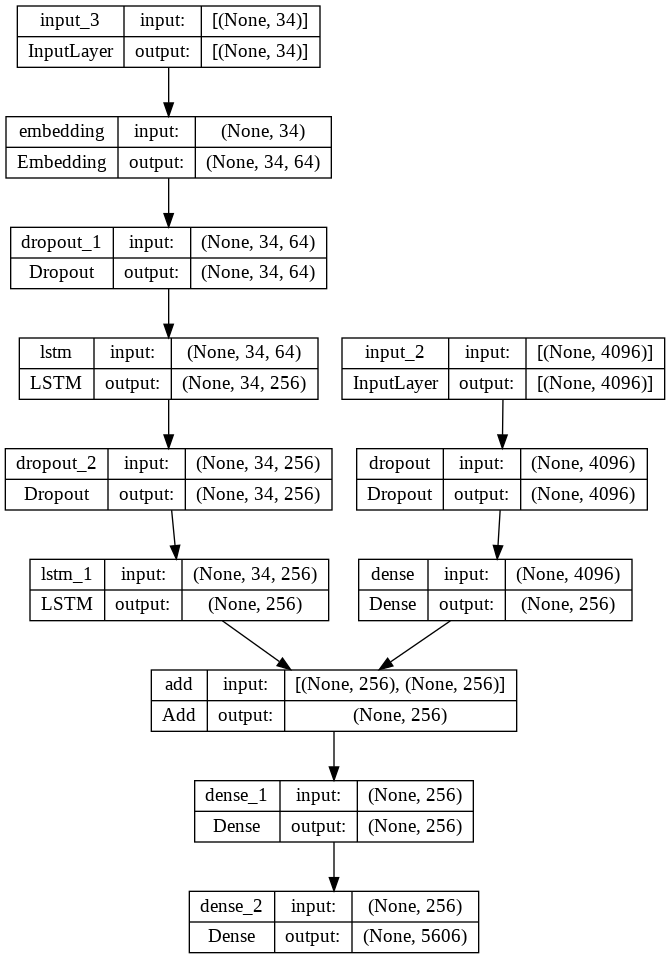

In [22]:
from keras import layers
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import LeakyReLU

from keras.layers import add, Dense, Embedding, Input, LSTM
from keras.utils import plot_model


print(len_vocab)

#Feature extraction model
input_image = Input(shape=(X_train_image.shape[1],))
feature_image1 = Dropout(0.5)(input_image)
feature_image2 = Dense(256, activation='relu')(feature_image1)

# Sequence Model (LSTM)
input_caption = Input(shape=(max_caption_len,))
seq_text1 = Embedding(len_vocab, 64, mask_zero=True)(input_caption)
# Caption Features1
seq_text2 = Dropout(0.5)(seq_text1)
seq_text3 = LSTM(256, return_sequences=True)(seq_text2)
# Caption Features2
seq_text4 = Dropout(0.04)(seq_text3)
seq_text5 = LSTM(256)(seq_text4)

# Merge models
decoder1 = add([seq_text5, feature_image2])
decoder2 = Dense(256, activation="relu")(decoder1)
output = Dense(len_vocab, activation='softmax')(decoder2)

# Image & Caption together
model = models.Model(inputs=[input_image, input_caption], outputs=output)

optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer= optimizer)

# Model Summary
print(model.summary())
plot_model(model, to_file='lstm_model.png', show_shapes=True)


## Train and validate model

In [23]:
from time import time
from keras.callbacks import TensorBoard

no_epochs = 5
batch_size = 32

tensorboard = TensorBoard(log_dir="./logs{}".format(time()))
hist = model.fit([X_train_image, X_train_text], y_train_text, epochs=no_epochs, verbose=1, batch_size=batch_size, validation_data=([X_val_image, X_val_text], y_val_text), callbacks = [tensorboard])

Epoch 1/5
2837/2837 [==============================] - 1039s 363ms/step - loss: 5.1667 - val_loss: 4.7703
Epoch 2/5
2837/2837 [==============================] - 1106s 390ms/step - loss: 4.3607 - val_loss: 4.5762
Epoch 3/5
2837/2837 [==============================] - 1125s 397ms/step - loss: 4.0422 - val_loss: 4.5253
Epoch 4/5
2837/2837 [==============================] - 1099s 387ms/step - loss: 3.8374 - val_loss: 4.5337
Epoch 5/5
2837/2837 [==============================] - 1092s 385ms/step - loss: 3.6873 - val_loss: 4.6168


## Train and Validation Loss Plots

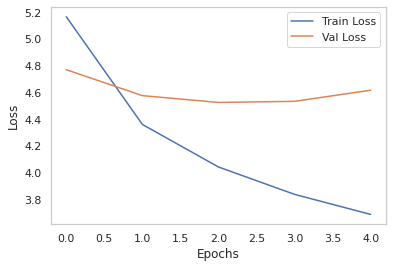

In [27]:
for loss_label in ["loss", "val_loss"]:
    if loss_label == "loss":
      l = "Train Loss"
    else:
      l = 'Val Loss'
    plt.plot(hist.history[loss_label], label=l)

plt.legend()
plt.grid(b=None)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Test Model

In [28]:
word_index = dict([(index, word) for word, index in tokenizer.word_index.items()])

def predict_caption(input_image):
    pred_caption = 'startseq'
    for i in range(max_caption_len):
        cptn_seq = tokenizer.texts_to_sequences([pred_caption])[0]
        cptn_seq = pad_sequences([cptn_seq], max_caption_len)
        pred = model.predict([input_image, cptn_seq], verbose=0)
        pred = np.argmax(pred)
        new_word = word_index[pred]
        pred_caption += " " + new_word
        if new_word =="endseq":
            break

    return pred_caption

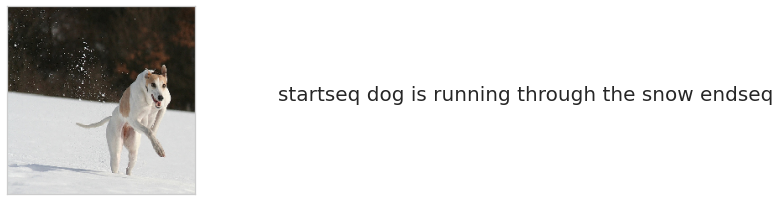

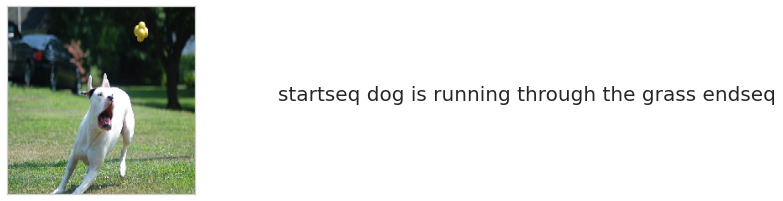

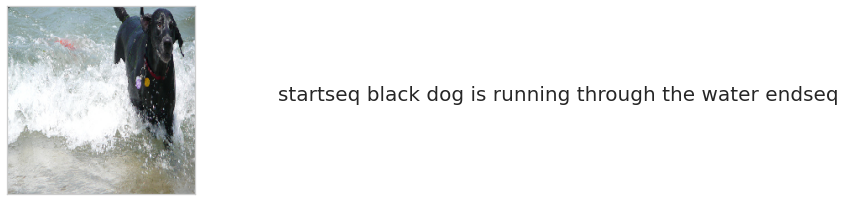

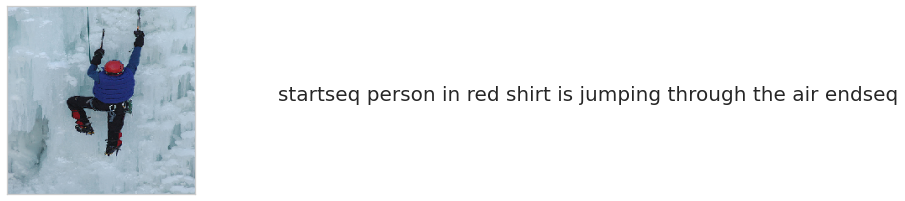

In [31]:
def show_caption(img_name, image):
    # Show Image
    cnt = 1
    fig = plt.figure(figsize=(10,20))

    file_name = flicker8k_images + '/' + img_name
    load_image = load_img(file_name, target_size= (224, 224, 3))
    ax = fig.add_subplot(5, 2, cnt, xticks=[], yticks=[])
    ax.imshow(load_image)
    cnt += 1
    
    ## Predict Caption
    pred_caption = predict_caption(image.reshape(1, len(image)))
    ax = fig.add_subplot(5, 2, cnt)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.text(0, 0.5, pred_caption, fontsize = 20)
    cnt += 1
    
    plt.show()

i = 18
show_caption(filename_test[5+i], image_test[5+i])
show_caption(filename_test[15+i], image_test[15])
show_caption(filename_test[25+i], image_test[25+i])
show_caption(filename_test[35+i], image_test[35+i])


### Predict captions on complete test data set and find BLEU score

In [32]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu 

count = 0
actual_caption, predicted_caption = [], []
previous_filename = ""
cpt = []

for filename, image, text in zip(filename_test, image_test, text_test):
    count += 1
    
    true_caption = [word_index[i] for i in text]
    true_caption = true_caption[1:-1]
    #actual_caption.append(true_caption)

    if previous_filename == filename:
      cpt.append(true_caption)
      continue
    else:
      if previous_filename != "":
        actual_caption.append(cpt)
      
      cpt = []
      cpt.append(true_caption)
      pred_caption = predict_caption(image.reshape(1, len(image)))
      pred_caption = pred_caption.split()
      pred_caption = pred_caption[1:-1]
      predicted_caption.append(pred_caption)
      
    previous_filename = filename

actual_caption.append(cpt)

In [34]:
# Print BLEU score
print('BLEU-1 Score: %f' % corpus_bleu(actual_caption, predicted_caption, weights=(1.0, 0, 0, 0)))
print('BLEU-2 Score: %f' % corpus_bleu(actual_caption, predicted_caption, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3 Score: %f' % corpus_bleu(actual_caption, predicted_caption, weights=(0.33, 0.33, 0.33, 0)))
print('BLEU-4 Score: %f' % corpus_bleu(actual_caption, predicted_caption, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1 Score: 0.442616
BLEU-2 Score: 0.246591
BLEU-3 Score: 0.134658
BLEU-4 Score: 0.072962


### Predict caption and calculate BLEU score for few images

In [36]:
def predict_test_data(filename, image, text):
  def caption_string(caption):
        true_str = ""
        for tkn in caption:
            true_str += " " + tkn
        return true_str
  
  ped_img = []
  
  caption_true = [word_index[i] for i in text]
  caption_true = caption_true[1:-1]
  caption_true = caption_string(caption_true)

  caption_pred = predict_caption(image.reshape(1, len(image)))
  caption_pred = caption_pred.split()
  caption_pred = caption_pred[1:-1]
  caption_pred = caption_string(caption_pred)

  bleu_score = sentence_bleu([caption_true], caption_pred)

  ped_img.append((bleu_score, filename, caption_true, caption_pred))

  file_name = flicker8k_images + '/' + filename
  load_image = load_img(file_name, target_size=(224, 224, 3))
  plt.grid(b=None)
  plt.imshow(load_image)
  print("Original captions:", caption_true)
  print("Predicted caption:", caption_pred)
  print("BLEU score:", bleu_score)

Original captions:  the black dog runs through the water
Predicted caption:  black dog is running through the water
BLEU score: 0.766947784217407


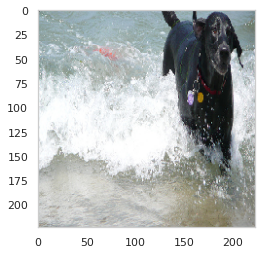

In [38]:
predict_test_data(filename_test[43], image_test[43], text_test[43])

Original captions:  people are watching hot air balloons in the park
Predicted caption:  group of people are playing in the air
BLEU score: 0.47724774408697285


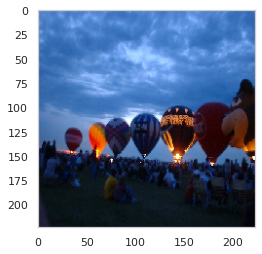

In [43]:
predict_test_data(filename_test[115], image_test[115], text_test[117])

Original captions:  black dog leaps over log
Predicted caption:  dog is running through the grass
BLEU score: 0.14380553624999493


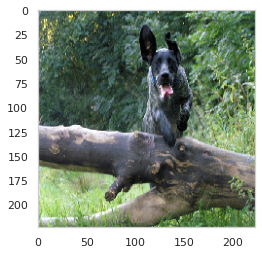

In [45]:
predict_test_data(filename_test[15], image_test[15], text_test[15])

Original captions:  boy in red soccer strip is holding his boots in his hand whilst stepping out of car
Predicted caption:  man in red jacket is standing on the the street
BLEU score: 0.20116368485908534


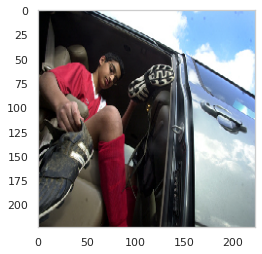

In [51]:
predict_test_data(filename_test[235], image_test[235], text_test[236])

Original captions:  the little boy runs into the ocean
Predicted caption:  dog is jumping through the water
BLEU score: 0.18861715935713982


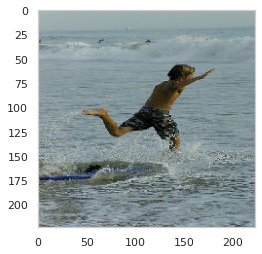

In [53]:
predict_test_data(filename_test[500], image_test[500], text_test[504])